# ASK-Modulation

## Abbildung des Bitstrom auf Datensymbole

Im Folgenden wird die Modulation eines binären Datenstrom per $M$-ASK demonstriert. Zunächst wird der binäre Datenstrom $u[k]$ auf die zeit- und wertediskreten Symbole $d[i]$ abgebildet. Diese sind bei einer ASK reellwertig. Bei der Abbildung wird eine Gray-Codierung verwendet.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

ECCpath = '../ECCpython'
if (not ECCpath==None) and (not ECCpath in sys.path):
    sys.path.append(ECCpath)

from Modulation.modulation import Modulation

# ---------------------------------------------------------------------------------
# parameter definition 

# cardinality of modulation scheme
M = 4
# number of information bits to be generated
N_info_bits = 64

# number of bits per ASK symbol
m = int(np.round(np.log2(M)))
# number of symbols obtained from information bits
N_symbols = N_info_bits // m
time_symbol = np.arange(N_symbols)

# ---------------------------------------------------------------------------------
# ASK alphabet
ask = Modulation(m, coding_type='gray',modulation_type='ASK')


In [2]:
# generate information bits u[k]
u = np.random.randint(0,2,N_info_bits)

# map bits to data symbols
d_ask_norm = ask.modulate(u)
d_ask = d_ask_norm * np.sqrt(ask.E)

(np.float64(0.0), np.float64(32.0), np.float64(-3.5), np.float64(4.0))

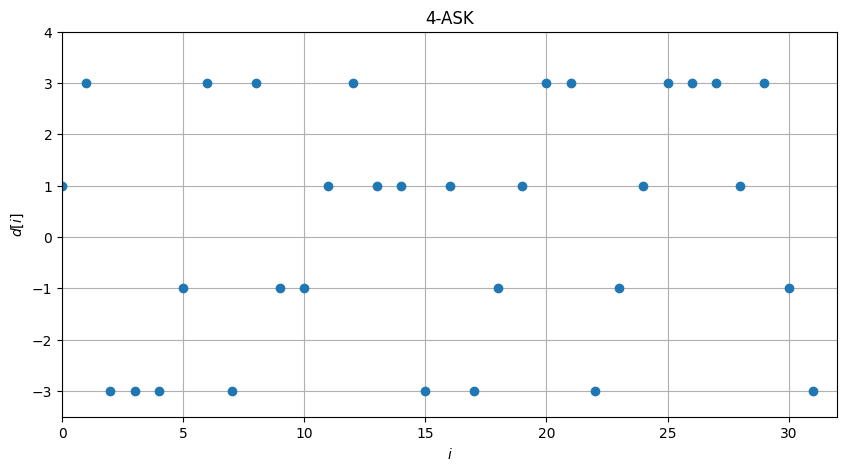

In [3]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(time_symbol, d_ask, marker='o',linestyle='none')
plt.xlabel('$i$')
plt.ylabel('$d[i]$')
plt.title('%g-ASK' %(M))
plt.grid(True)
plt.axis([0, 32, -3.5, 4])

## Sendefilter 

Die Datensymbolfolge $d[k]$ muss nun in ein analoges, d.h. zeit- und wertekontinuierliches Signal $x(t)$ überführt werden. Dazu dient das Sendefilter, mit dessen Impulsantwort $g_S(t)$ die Datenfolge zu falten ist. Wir erhalten das analoge Signal

\begin{equation}
    x(t) = T_s \cdot d[i] \ast g_S(t) = T_s \cdot \sum_i d[i] \cdot g_S(t-iT_s) \; .
\end{equation}

Zusammen mit dem Empfangsfilter $g_E(t)$ ist die 1. Nyquist-Bedingung 

\begin{equation}
    T_s \cdot g(i T_s) = 
    \begin{cases}
        1 & \text{für } i = 0 \\
        0 & \text{für } i \neq 0 
    \end{cases}
    \qquad \text{mit} \qquad
    g(t) = g_E(t) \ast g_S(t)
\end{equation}

zu erfüllen. Wichtig ist, dass die Gesamtimpulsantwort $g(t)$ die 1. Nyquist-Bedingung erfüllen muss, nicht aber die separaten Impulsantworten von Sende- und Empfangsfilter. 

Neben dem idealen Tiefpass mit si-förmiger Impulsantwort erfüllen auch alle Filter, deren Impulsantwort aus einer Fensterung des idealen Tiefpasses hervorgehen, die 1. Nyquist-Bedingung. In der Praxis werden häufig Wurzel-Kosinus-Rolloff-Filter mit der Impulsantwort

\begin{equation}
    g_{\mathrm{RRC}}(t) = \frac{4 r \frac{t}{T_S} \cos \left(\pi (1+r) \frac{t}{T_S} \right) + \sin \left( \pi (1-r) \frac{t}{T_S} \right)}{\left( 1- \left(4r \frac{t}{T_S} \right)^2 \right) \pi t}
\end{equation}

dem Roll-Off-Faktor $r$ und der Nyquist-Kreisfrequenz $\omega_{\mathrm{N}}=\frac{\pi}{T_S}$ eingesetzt. Die Übertragungsfunktion lautet

\begin{equation}
    G_{\mathrm{RRC}}(j \omega) = 
    \begin{cases} 
        1 & \text{für } \frac{|\omega|}{\omega_{\mathrm{N}}} \leq 1-r \\
        \cos \left( \frac{\pi}{4r} \left( \frac{|\omega|}{\omega_{\mathrm{N}}} - (1-r) \right) \right)
        & \text{für } 1 - r \leq \frac{|\omega|}{\omega_{\mathrm{N}}} \leq 1+r \\
        0 & \text{für } \frac{|\omega|}{\omega_{\mathrm{N}}} \geq 1+r 
    \end{cases}
\end{equation}

Das Empfangsfilter als Matched-Filter ist ebenfalls ein Wurzelkosinus-Rolloff-Filter. Beide zusammen resultieren in einer Kosinus-Rolloff-Charakteristik mit der Gesamtimpulsantwort

\begin{equation}
    g_{\mathrm{RC}}(t) = \frac{1}{T_S} \cdot \frac{\sin(\pi t/Ts)}{\pi t/T_S} \cdot \frac{\cos(r \pi t/T_S)}{1-(2rt/T_S)^2}
\end{equation}

und der Übertragungsfunktion

\begin{equation}
    G_{\mathrm{RC}}(j \omega) = 
    \begin{cases} 
        1 & \text{für } \frac{|\omega|}{\omega_{\mathrm{N}}} \leq 1-r \\
        \frac{1}{2} \cdot \left[ 1 + \cos \left( \frac{\pi}{2r} \left( \frac{|\omega|}{\omega_{\mathrm{N}}} - (1-r) \right) \right) \right]
        & \text{für } 1 - r \leq \frac{|\omega|}{\omega_{\mathrm{N}}} \leq 1+r \\
        0 & \text{für } \frac{|\omega|}{\omega_{\mathrm{N}}} \geq 1+r  \; .
    \end{cases}
\end{equation}

Die Verläufe von Kosinus- und Wurzel-Kosinus-Rolloff-Filtern im unteren Bild verdeutlichen, dass die 1. Nyquist-Bedingung nur für das Gesamtfilter mit der Impulsantwort $g(t)=g_{\mathrm{RC}}(t)$ erfüllt ist.


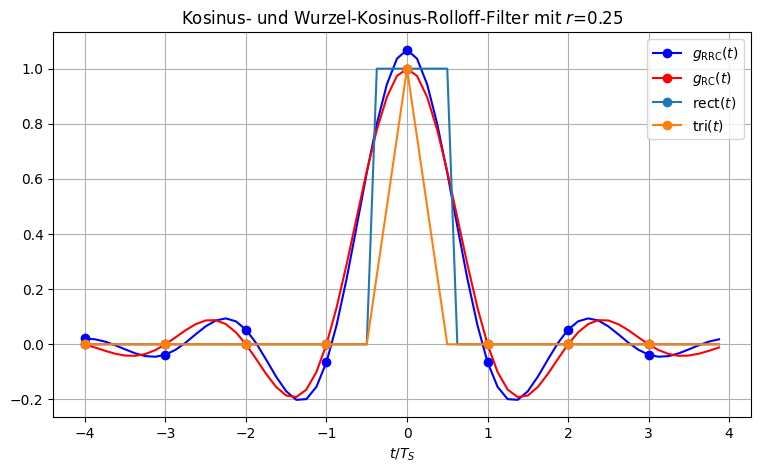

In [4]:
# symbol duration in seconds
Ts = 1e-6
# oversampling factor
w = 8
# sampling rate in Hz
fa = w / Ts
# length of filter impulse response in samples
N_rc = 8*w

# roll-off factor of Root-Raised-Cosine filter
r = 0.25
_,g_rrc   = ask.rrcosfilter(N_rc,r,Ts,fa)
time,g_rc = ask.rcosfilter(N_rc,r,Ts,fa)

# rectangular filter
_,g_rect = ask.rectangularfilter(N_rc,Ts,fa)

# triangular filter
_,g_tri = ask.triangularfilter(N_rc,Ts,fa)

time = time / Ts

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.plot(time,g_rrc, 'b-o', markevery=(w), label='$g_{\mathrm{RRC}}(t)$')
ax.plot(time,g_rc, 'r-o', markevery=(w), label='$g_{\mathrm{RC}}(t)$')
ax.plot(time,g_rect, '-o', markevery=(w), label='rect$(t)$')
ax.plot(time,g_tri, '-o', markevery=(w), label='tri$(t)$')
plt.xlabel('$t/T_S$')
plt.title('Kosinus- und Wurzel-Kosinus-Rolloff-Filter mit $r$=%1.2f' %(r))
plt.grid(True)
plt.legend()


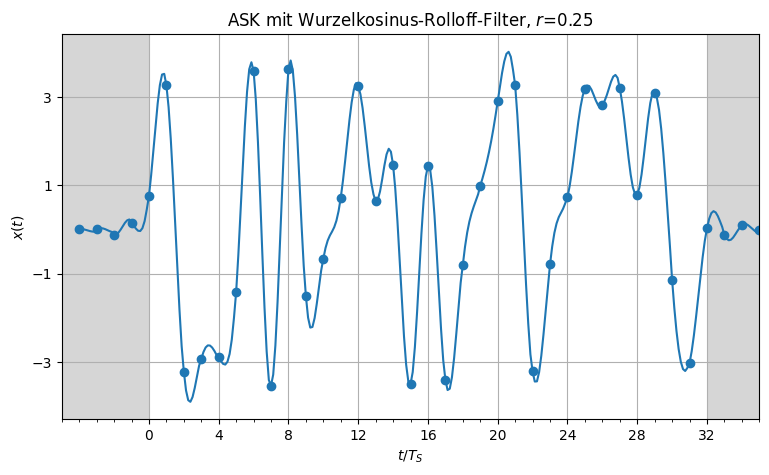

In [5]:
# oversampling data symbols by inserting w zeros 
x = np.append(np.reshape(d_ask,(N_symbols,1)),np.zeros((N_symbols,w-1)),axis=1)
x = np.reshape(x,(N_symbols*w,1))

x_rrc = np.convolve(x.flatten(),g_rrc)
time = (np.arange(N_symbols*w+N_rc-1)-N_rc/2) / w

fig = plt.figure(figsize=(9,5))
from matplotlib.ticker import AutoMinorLocator
ax = fig.add_subplot(111)
ax.plot(time,x_rrc, marker='o',markevery=w)
plt.xlabel('$t/T_S$')
plt.ylabel('$x(t)$')
plt.title('ASK mit Wurzelkosinus-Rolloff-Filter, $r$=%1.2f' %(r))
plt.grid(True)
plt.xticks(np.arange(0,33,4))
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(ask.constellation)
plt.xlim(-5,35)
plt.axvspan(-5, 0, facecolor='0.2', alpha=0.2)
plt.axvspan(32, 35, facecolor='0.2', alpha=0.2)

Im obigen Bild ist ein exemplarischer Verlauf der (komplexen) Einhüllenden $x(t)$ dargestellt, wobei die Marker die idealen Abtastzeitpunkte markieren. Man erkennt, dass an den idealen Abtastzeitpunkten nicht exakt die gewünschten Symbolwerte $\{ \pm 3, \pm 1\}$ auftreten, sondern leicht größere oder kleinere Werte. Dies liegt an den Intersymbolinterferenzen, da das Wurzel-Kosinus-Rolloff-Filter nicht die erste Nyquist-Bedingung erfüllt. Die Ein- und Ausschwingvorgänge am Anfang ($t<0$) und Ende ($t>32T_S$) des Signalverlaufs sind zu vernachlässigen.

Demgegenüber zeigt das untere Bild, dass bei einem Kosinus-Rolloff-Filter zu den idealen Abtastzeitpunkten die erwarteten Symbolwerte abzulesen sind und die 1. Nyquist-Bedingung erfüllt wird.

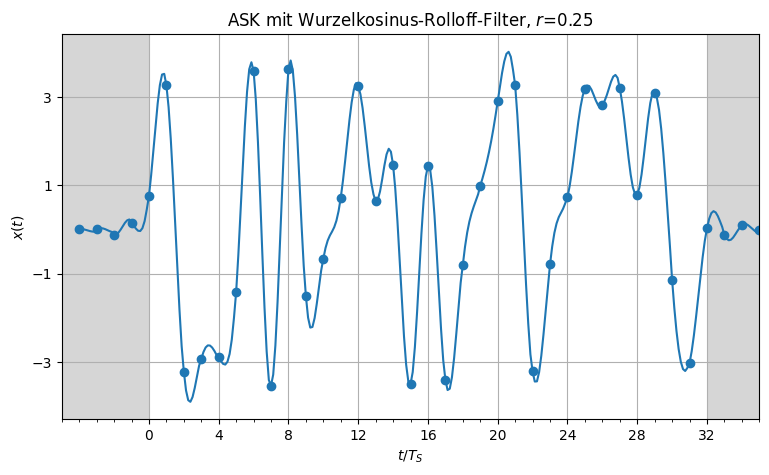

In [6]:
x_rc = np.convolve(x.flatten(),g_rc)

fig = plt.figure(figsize=(9,5))
from matplotlib.ticker import AutoMinorLocator
ax = fig.add_subplot(111)
ax.plot(time,x_rrc, marker='o',markevery=w)
plt.xlabel('$t/T_S$')
plt.ylabel('$x(t)$')
plt.title('ASK mit Wurzelkosinus-Rolloff-Filter, $r$=%1.2f' %(r))
plt.grid(True)
plt.xticks(np.arange(0,33,4))
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(ask.constellation)
plt.xlim(-5,35)
plt.axvspan(-5, 0, facecolor='0.2', alpha=0.2)
plt.axvspan(32, 35, facecolor='0.2', alpha=0.2)

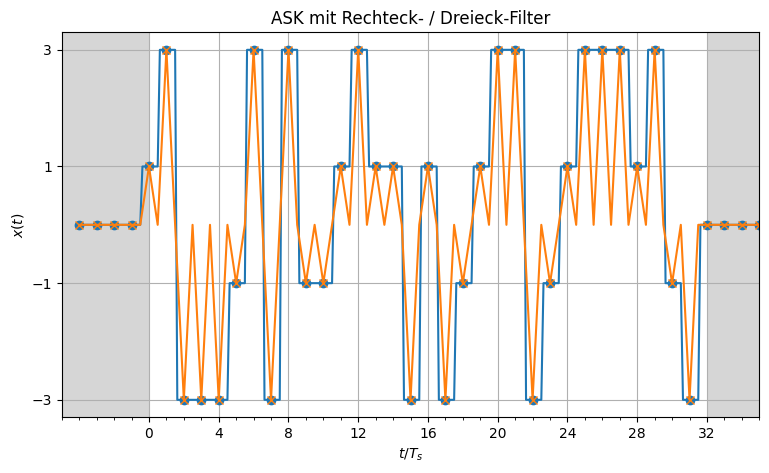

In [7]:
x_rc = np.convolve(x.flatten(),g_rc)

x_rect = np.convolve(x.flatten(),g_rect)
x_tri = np.convolve(x.flatten(),g_tri)


fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.plot(time,x_rect, marker='o',markevery=(w),label='rect')
ax.plot(time,x_tri, marker='x',markevery=(w),label='tri')
plt.xlabel('$t/T_s$')
plt.ylabel('$x(t)$')
plt.title('ASK mit Rechteck- / Dreieck-Filter')
plt.grid(True)
plt.xticks(np.arange(0,33,4))
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(ask.constellation)
plt.xlim(-5,35)
plt.axvspan(-5, 0, facecolor='0.2', alpha=0.2)
plt.axvspan(32, 35, facecolor='0.2', alpha=0.2)

## Augendiagramm

Das Augendiagramm ist ein graphisches Hilfsmittel, um die Übertragungsqualität zu beurteilen. Um es anzuzeigen wird das Signal $x(t)$ in Abschnitte der Dauer $T_S$ unterteilt und diese werden in einem Diagramm übereinander gezeichnet. Für das Kosinus-Rolloff-Filter erhalten wird das untere Bild. Es ist deutlich zu erkenne, dass am idealen Abtastzeitpunkt die Symbolwerte der 4-ASK abzulesen sind. Damit ist die vertikale Augenöffnung ideal und die 1. Nyquist-Bedingung erfüllt. Die horiziontale Augenöffnung ist hingegen nicht maximal, sondern auf etwa $0.37\ T_S$ begrenzt, was in der Wahl des Rolloff-Faktors von $r=0.25$ begründet ist.

(np.float64(-0.5), np.float64(0.5), np.float64(-4.0), np.float64(4.0))

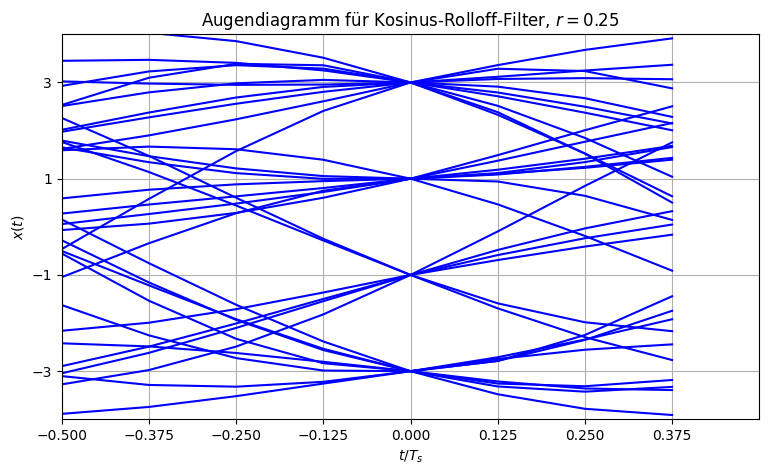

In [14]:
start = int((len(g_rc)-w)/2) 
stop  = start + N_symbols * w 
eye_rc = np.reshape(x_rc[start:stop],(w,N_symbols),order='f')
eye_rrc = np.reshape(x_rrc[start:stop],(w,N_symbols),order='f')
eye_time = np.arange(-Ts/2,Ts/2,1/fa) / Ts

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.plot(eye_time,eye_rc, 'b-')
plt.xlabel('$t/T_s$')
plt.ylabel('$x(t)$')
plt.title('Augendiagramm für Kosinus-Rolloff-Filter, $r=$%1.2f' %(r))
plt.grid(True)
plt.xticks(np.arange(-0.5,0.5,1/w))
plt.yticks(ask.constellation)
plt.axis([-0.5, 0.5, -4.0, 4.0])

Das Wurzel-Kosinus-Rolloff-Filter erfüllt wie bereits erwähnt nicht die 1. Nyquist-Bedingung. Dies ist am unteren Augendiagramm zu erkennen. Die vertikale Augenöffnung ist gegenüber der obigen Abbildung deutlich reduziert, die Symbolwerte der ASK können nicht störungsfrei abgelesen werden.

([<matplotlib.axis.YTick at 0x7f6becbb60b0>,
 [Text(0, -3, '−3'), Text(0, -1, '−1'), Text(0, 1, '1'), Text(0, 3, '3')])

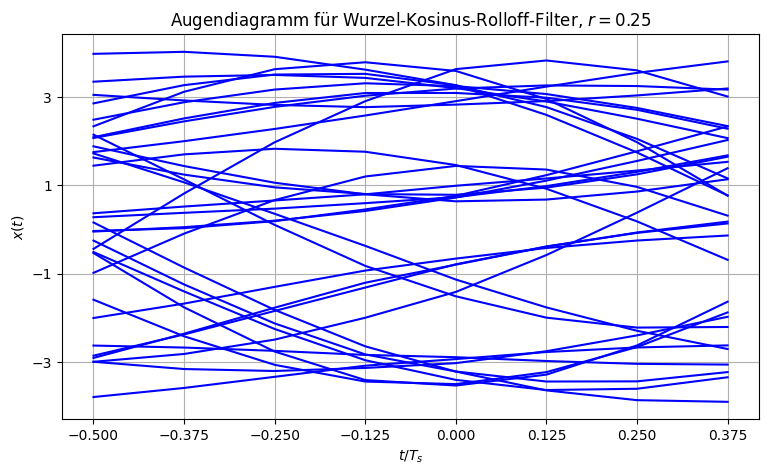

In [10]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.plot(eye_time,eye_rrc, 'b-')
plt.xlabel('$t/T_s$')
plt.ylabel('$x(t)$')
plt.title('Augendiagramm für Wurzel-Kosinus-Rolloff-Filter, $r=$%1.2f' %(r))
plt.grid(True)
plt.xticks(np.arange(-0.5,0.5,1/w))
plt.yticks(ask.constellation)

## Verschiebung in das Übertragungsband

Zur Verschiebung in das Übertragungsband ist das Basisbandsignal $x(t)$ mit der Trägerschwingung zu multiplizieren, $x(t)$ moduliert sozusagen die Trägerschwingung. Mathematisch erhalten wir

\begin{equation}
    x_{\mathrm{ASK}}(t) = \mathrm{Re} \{ x(t) \cdot e^{j \omega_0t} \} = x(t) \cdot \cos(\omega_0t) \; .
\end{equation}  

Das unten folgende Bild veranschaulicht das sich ergebende Zeitsignal. Um die hochfrequente Trägerschwingung mit $f_0=5$ MHz zu visualisieren, wurde die Überabtastung um den Faktor $w_2$ erhöht. Das blaue Zeitsignal wird durch die rot dargestellt Einhüllende nach oben und nach unten begrenzt.

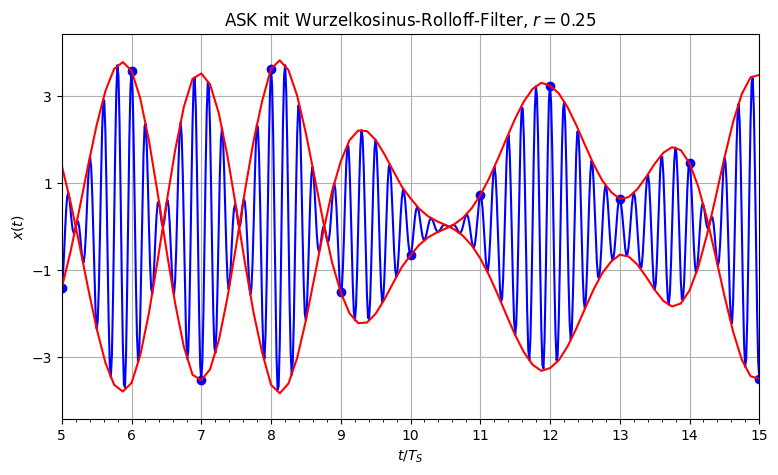

In [11]:
# carrier frequency in Hz
f0 = 5e6
# additional oversampling factor
w2 = 8
# sampling rate in Hz
fa2 = fa * w2
# length of filter impulse response in samples
N_rc2 = N_rc*w2
tmp,g_rrc2 = ask.rrcosfilter(N_rc2,r,Ts,fa2)
tmp,g_rc2 = ask.rcosfilter(N_rc2,r,Ts,fa2)

# oversampling data symbols by inserting w zeros 
x2 = np.append(np.reshape(d_ask,(N_symbols,1)),np.zeros((N_symbols,w*w2-1)),axis=1)
x2 = np.reshape(x2,(N_symbols*w*w2,1))

x_rrc2 = np.convolve(x2.flatten(),g_rrc2)
time2 = (np.arange(N_symbols*w*w2+N_rc2-1)-N_rc2/2) / w/w2
x_rrc2 = x_rrc2 * np.cos(2 * np.pi * f0 * time2*Ts)

fig = plt.figure(figsize=(9,5))
from matplotlib.ticker import AutoMinorLocator
ax = fig.add_subplot(111)
ax.plot(time2,x_rrc2, 'b-o',markevery=w*w2)
ax.plot(time,x_rrc, 'r-',markevery=w)
ax.plot(time,-x_rrc, 'r-',markevery=w)
plt.xlabel('$t/T_S$')
plt.ylabel('$x(t)$')
plt.title('ASK mit Wurzelkosinus-Rolloff-Filter, $r=$%1.2f' %(r))
plt.grid(True)
plt.xticks(np.arange(0,33,1))
ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(ask.constellation)
plt.xlim(5,15)
plt.axvspan(-5, 0, facecolor='0.2', alpha=0.2)
plt.axvspan(32, 35, facecolor='0.2', alpha=0.2)

## Leistungsdichtespektrum 

Da das modulierte Signal ein stochastisches Signal ist, kann nicht einfach die Fourier-Transformierte zur Bestimmung des Spektrums berechnet werden. Vielmehr wird das Leistungdichtespektrum verwendet, das die mittlere Verteilung der Leistung über der Frequenz angibt. Es berechnet sich nach dem Theorem von Wiener und Khintchine aus der Fourier-Transformierten der Autokorrelationsfunktion. Für mittelwertfreie, identisch verteilte und statistisch unabhängige Datensymbole (i.i.d.) lautet die spektrale Leistungsdichte

\begin{equation}
    \Phi_{{\cal XX}}(j \omega) = \sigma_D^2 \cdot T_S \cdot |G_S(j \omega)|^2
\end{equation}

Es hängt also bis auf eine Skalierung mit $\sigma_D^2 \cdot T_S$ nur vom Betragsquadrat der Übertragungsfunktion des Sendefilters ab.

Für eine akzeptable Auflösung im Frequenzbereich benötigen wir deutlich längere Sequenzen. Im folgenden Code-Segment wird daher ein längeres ASK-Signal erzeugt und dann das Leistungsdichtespektrum mit Hilfe der Welch-Methode geschätzt. 

In [12]:
from scipy import signal

# number of ASK symbols
N = 1000

# averaging for power density spectrum
Npsd = 10

# generate information bits
u = np.random.randint(0,2,N*m)

# map bit sequence to ASK symbols
d = ask.modulate(u)
    
# upsampling and convolution with impulse response of RRC filter    
x = np.append(np.reshape(d,(N,1)),np.zeros((N,w-1)),axis=1)
x = np.reshape(x,(N*w,1))

x_r = np.convolve(x.flatten(),g_rrc)
time = (np.arange(N*w+N_rc-1)-N_rc/2) / w  


# estimation of power spectral density with Welch method
f, psd = signal.welch(x_r, fs=fa, nperseg=N*w/Npsd, return_onesided=False, scaling='spectrum',axis=0)

# rearrange positive and negative frequencies
f = np.fft.fftshift(f)
psd = np.fft.fftshift(psd) * N_rc

# analytical solution of power spectral density equals squared magnitude of transfer function of root-raised-cosine transmit filter
# squared magnitude of root-raised-cosine characteristic equals raised-cosine characteristic
# solution normalized to maximum value of 1 (divided by T_s sigma_D^2)
G_RC = 0.5 * (1 + np.cos(np.pi/(2*r)*(np.abs(f)*2*Ts-(1-r))))
ptr = np.argwhere(np.abs(f)*2*Ts<1-r)
G_RC[ptr.flatten()] = 1.0
ptr = np.argwhere(np.abs(f)*2*Ts>1+r)
G_RC[ptr.flatten()] = 0.0

(np.float64(-2.0), np.float64(2.0), np.float64(1e-06), np.float64(2.0))

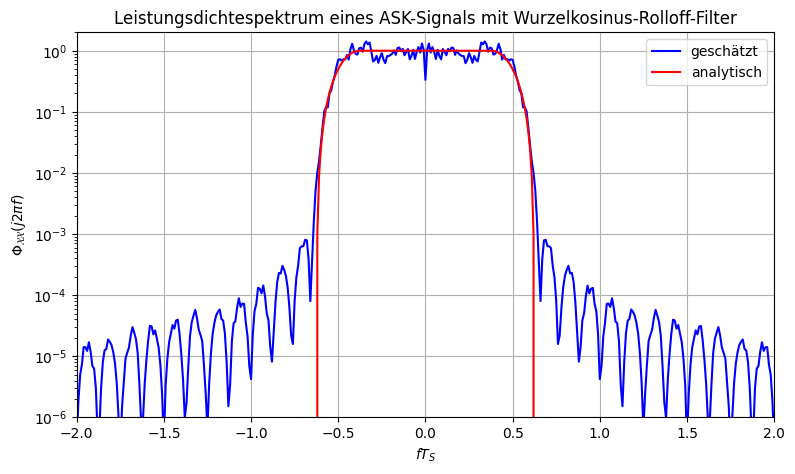

In [13]:
fig_psd = plt.figure(figsize=(9,5))
ax = fig_psd.add_subplot(111)
ax.semilogy(f*Ts, psd,'b-',label='geschätzt')
ax.semilogy(f*Ts, G_RC,'r-',label='analytisch')
plt.title('Leistungsdichtespektrum eines ASK-Signals mit Wurzelkosinus-Rolloff-Filter')
plt.xlabel('$f T_S$')
plt.ylabel('$\Phi_{\cal XX}(j 2 \pi f)$')
plt.legend()
plt.grid(True)
plt.axis([-2, 2, 1e-6, 2])

Dem obigen Bild ist zu entnehmen, dass die analytische Berechnung gut mit dem geschätzten Leistungsdichtespektrum übereinstimmt. Es ist auch zu erkennen, dass für den Rolloff-Faktor $r=0.25$ die Bandbreite $B_{NF} = (1+r) \cdot f_N = \frac{1.25}{2 T_S} = 0.625$ MHz beträgt. Die Rippel des geschätzten Spektrum resultieren aus der zeitlichen Begrenzung der Impulsantwort $g_{\mathrm{RRC}}(t)$ des Sendefilters. Letzteres entspricht einer Multiplikation mit einem Rechteck, was im Frequenzbereich zu einer Faltung mit der zugehörigen si-Funktion wird. Außerdem sorgen die endliche Datenmenge und die Fensterung mit dem Hanning-Fenster nach dem Welch-Ansatz für leichte Ungenauigkeiten. 